<a href="https://colab.research.google.com/github/zacharylazzara/Connectome-Exploration/blob/main/Connectome_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Please save a copy of this notebook into your Google Drive before making changes, otherwise your changes will not be saved!**

In [ ]:
#@title Settings
#@markdown Leave N_ROWS blank (or set it to a negative number) to use the entire dataset.
DEBUG = False #@param {type:"boolean"}
VERBOSE = False #@param {type:"boolean"}
N_ROWS = 5000 #@param {type:"integer"}

if N_ROWS < 0:
  N_ROWS = None

# Setup

In [ ]:
#@title Download and Extract FlyEM Connectome
%%bash
gdown 1bQ3WRHkR9Qa4-iOX1nI5HLxKk-u415oZ
tar -xvf conn_summary.tar

exported-traced-adjacencies/
exported-traced-adjacencies/traced-total-connections.csv
exported-traced-adjacencies/traced-roi-connections.csv
exported-traced-adjacencies/traced-neurons.csv
exported-traced-adjacencies/._README
exported-traced-adjacencies/README


Downloading...
From: https://drive.google.com/uc?id=1bQ3WRHkR9Qa4-iOX1nI5HLxKk-u415oZ
To: /content/conn_summary.tar
100%|██████████| 199M/199M [00:02<00:00, 77.1MB/s]


In [ ]:
#@title Python Imports
!sudo apt-get -qq install python3-dev graphviz libgraphviz-dev pkg-config
!pip install -q pygraphviz

import pandas as pd
from tqdm.notebook import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from enum import Enum
import numpy as np

from google.colab import data_table
data_table.enable_dataframe_formatter()


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 9.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libgtk2.0-common.
(Reading database ... 120876 files and directories currently installed.)
Preparing to unpack .../0-libgtk2.0-common_2.24.33-2ubuntu2_all.deb ...
Unpacking libgtk2.0-common (2.24.33-2ubuntu2) ...
Selecting previously unselected package libgtk2.0-0:amd64.
Preparing to unpack .../1-libgtk2.0-0_2.24.33-2ubuntu2_amd64.deb ...
Unpacking libgtk2.0-0:amd64 (2.24.33-2ubuntu2) ...
Selecting previously unselected package libgail18:amd64.
Preparing to unpack .../2-libgail18_2.24.33-2ubuntu2_amd64.deb

In [ ]:
#@title Load CSVs
traced_neurons = pd.read_csv('exported-traced-adjacencies/traced-neurons.csv', nrows=N_ROWS).astype({'bodyId': 'Int64', 'instance': 'string', 'type': 'string'})
traced_total_connections = pd.read_csv('exported-traced-adjacencies/traced-total-connections.csv', nrows=N_ROWS).astype({'bodyId_pre': 'Int64', 'bodyId_post': 'Int64', 'weight': 'Int64'})
traced_region_of_interest_connections = pd.read_csv('exported-traced-adjacencies/traced-roi-connections.csv', nrows=N_ROWS).astype({'bodyId_pre': 'Int64', 'bodyId_post': 'Int64', 'roi': 'string', 'weight': 'Int64'})

In [ ]:
#@title Associate Data Hierarchy
ttc_index = pd.MultiIndex.from_frame(traced_total_connections, names=['id', 'id_post', 'weight_syn'])
traced_total_connections.set_index(ttc_index, inplace=True)

tn_index = pd.MultiIndex.from_frame(traced_neurons, names=['id', 'instance', 'type'])
traced_neurons.set_index(tn_index, inplace=True)

neural_dataset = traced_neurons.merge(traced_total_connections, left_on=['id'], right_on=['id'], how='outer').merge(traced_region_of_interest_connections.rename(columns={'bodyId_pre': 'bodyId'}), on=['bodyId', 'bodyId_post'], how='outer').rename(columns={'weight_x': 'weight_syn', 'weight_y': 'weight_roi'}).fillna(pd.NA)
neural_dataset.drop(columns=['bodyId_pre'], inplace=True) # bodyId_pre is no longer needed as it is equal to bodyId for each record

nd_index = pd.MultiIndex.from_frame(neural_dataset)#, names=['id', 'instance', 'type', 'id_post', 'weight_syn', 'roi', 'weight_roi'])
neural_dataset.set_index(nd_index, inplace=True, verify_integrity=True)


# Main

In [ ]:
#@title Show Table
data_table.DataTable(neural_dataset, include_index=False)

# TODO: we should be able to drop bodyId_pre because it's the same as bodyId now that the data is associated

In [ ]:
#@title Classes

# TODO: the goal here is to turn those CSVs into a spiking neural network.
# First we need to figure out how they're connected and model that. Then we can
# automate the conversion of our model into a spiking neural network.

# Superclasses (they shouldn't implement any functionality; maybe they should be abstract?)
class Neuron:
  def __repr__(self):
    return f"Neuron({self.bodyId}, {self.nType}, {self.nInstance}, {self.initial}, {self.synapses})"

  def __init__(self, bodyId, nType, nInstance):
    self.bodyId = bodyId
    self.nType = nType
    self.nInstance = nInstance
    self.initial = True # If there's no upstream connection the neuron is initial
    self.synapses = [] # Only downstream connections go in this list

  def associateDownstreamSynapse(self, synapse):
    self.synapses.append(synapse) # TODO: probably wise to make sure we don't allow the same ID if it's already here?

  def isInitial(self):
    return self.initial

  def isTerminal(self):
    return not bool(self.synapses)

  def stimulate(self):
    raise NotImplementedError("This method must be implemented by a subclass.")


class RegionOfInterest:
  def __repr__(self):
    return f"RegionOfInterest({self.roi}, {self.weight})"

  def __init__(self, roi, weight: int):
    self.roi = roi
    self.weight = weight


class Synapse:
  def __repr__(self):
    return f"Synapse({self.weight}, {self.roi}, {self.neuron})"

  def __init__(self, neuron: Neuron, weight: int, roi: RegionOfInterest=None):
    self.neuron: Neuron = neuron # The downstream neuron
    self.neuron.initial = False
    self.weight: int = weight # The total number of synapses between the neuron pair (should never be negative or 0)
    self.roi = roi

In [ ]:
#@title Neurons

# Debugging; uncomment to use system in a working state

neurons: dict[str:Neuron] = {}
for _, neuron in tqdm(neural_dataset.iterrows(), total=len(neural_dataset)):
  neurons[neuron['bodyId']] = Neuron(neuron['bodyId'], neuron['type'], neuron['instance'])

  0%|          | 0/10688 [00:00<?, ?it/s]

In [ ]:
#@title Associate Data

# Debugging; uncomment to use system in a working state

skipped = 0
for _, connection in tqdm(neural_dataset.iterrows(), total=len(neural_dataset)):
  pre_neuron = neurons[connection['bodyId']]
  try:
    pre_neuron.associateDownstreamSynapse(Synapse(neurons[connection['bodyId_post']], connection['weight_syn'], RegionOfInterest(connection['roi'], connection['weight_roi'])))
  except KeyError:
    if VERBOSE:
      print(f"Skipping ID {connection['bodyId_post']} as it does not exist in list of neurons.")
    else:
      skipped += 1
if skipped > 0:
  print(f"Skipped {skipped} post-neuron(s) as their IDs were not present in the total neuron list.")

  0%|          | 0/10688 [00:00<?, ?it/s]

Skipped 9344 post-neuron(s) as their IDs were not present in the total neuron list.


In [ ]:
# TODO: try to do it all in one
# NOTE: The commented out code works except it seems to fail for graphing, so there's some issue with this implementation (TODO: fix it)

# Debugging; comment out to use system in a working state

# neurons: dict[str:Neuron] = {}
# for _, neuron_data in tqdm(neural_dataset.iterrows(), total=len(neural_dataset)):
#   if neuron_data['bodyId'] not in neurons:
#     neurons[neuron_data['bodyId']] = Neuron(neuron_data['bodyId'], neuron_data['type'], neuron_data['instance'])

#   for data in neural_dataset.loc[neuron_data['bodyId_post'] == neural_dataset['bodyId']].iterrows():
#     downstream_data = data[1]
#     post_neuron = Neuron(downstream_data['bodyId'], downstream_data['type'], downstream_data['instance'])
#     neurons[neuron_data['bodyId']].associateDownstreamSynapse(Synapse(post_neuron, neuron_data['weight_syn'], RegionOfInterest(neuron_data['roi'], neuron_data['weight_roi'])))

In [ ]:
#@title Debug
if DEBUG:
  print("=== DEBUG ===")
  for neuron in neurons.values():
    print(neuron)
else:
  print("Skipped debugging.")

Skipped debugging.


# Graph

In [ ]:
#@title Graph Settings
GRAPH = True #@param {type:"boolean"}
figure_height = 10 #@param {type:"integer"}
figure_width = 10 #@param {type:"integer"}
node_size = 20 #@param {type:"integer"}
node_shape = 'o' #@param {type:"string"}
line_radius = 0 #@param {type:"integer"}
line_style = 'solid' # @param ["solid", "dotted", "dashed", "dashdot"]
show_labels = False #@param {type:"boolean"}
hide_disconnected_neurons = True #@param {type:"boolean"}
font_size = 5 #@param {type:"integer"}
null_synapse_weight = 0 #@param {type:"number"}
weight_scaling = 0.1 #@param {type:"number"}

# Colour settings
line_color = 'black'
initial_color = 'cyan'
connected_color = 'magenta'
terminal_color = 'orange'
disconnected_color = 'gray'
null_color = 'red'

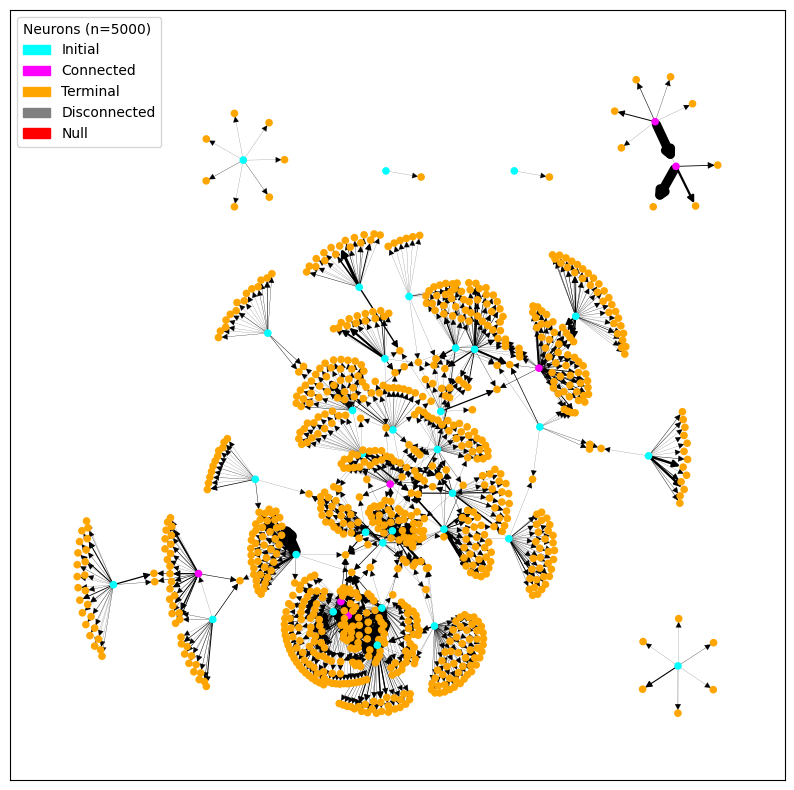

In [ ]:
#@title Graph

# TODO: if null_synapse_weight is > 0 this breaks. The issue seems to have something to do
# with the node colours

# TODO: to make graph work with the new changes remember that we might have extra neurons
# now, since the system no longer checks if they exist in the list (i.e., we can have IDs
# from beyond the list?)


if GRAPH:
  G = nx.DiGraph()

  if null_synapse_weight > 0:
    G.add_node('NULL', color=null_color)

  for neuron in neurons.values():
    node_color = None
    if neuron.isTerminal():
      node_color = disconnected_color if neuron.isInitial() else terminal_color
      if null_synapse_weight > 0:
        G.add_edge(neuron.bodyId, 'NULL', color=null_color, weight=null_synapse_weight)
    else:
      node_color = initial_color if neuron.isInitial() else connected_color
      for synapse in neuron.synapses:
        G.add_edge(neuron.bodyId, synapse.neuron.bodyId, color=line_color, weight=synapse.weight)

    if not (neuron.isTerminal() and neuron.isInitial() and hide_disconnected_neurons):
      G.add_node(neuron.bodyId, color=node_color)

  node_colors = nx.get_node_attributes(G,'color').values()
  edge_colors = nx.get_edge_attributes(G,'color').values()
  edge_weights = nx.get_edge_attributes(G,'weight')
  synaptic_weights = [G[u][v]['weight'] * weight_scaling for u,v in G.edges()]

  pos = nx.nx_agraph.graphviz_layout(G)

  plt.figure(3, figsize=(figure_width, figure_height))
  if show_labels:
    nx.draw_networkx_labels(G, pos, font_size=font_size)
    nx.draw_networkx_edge_labels(G, pos, edge_weights, font_size=font_size)
  nx.draw_networkx_nodes(G, pos, node_shape=node_shape, node_size=node_size, node_color=node_colors)
  nx.draw_networkx_edges(G, pos, width=synaptic_weights, node_shape=node_shape, node_size=node_size, edge_color=edge_colors, arrows=True, style=line_style, connectionstyle=f'arc3,rad={line_radius}')

  plt.legend(title=f'Neurons (n={len(neurons)})', handles=[
      mpatches.Patch(color=initial_color, label='Initial'),
      mpatches.Patch(color=connected_color, label='Connected'),
      mpatches.Patch(color=terminal_color, label='Terminal'),
      mpatches.Patch(color=disconnected_color, label='Disconnected'),
      mpatches.Patch(color=null_color, label='Null')
  ])._legend_box.align = 'left'

  plt.show()
else:
  print("Skipped graphing.")

In [ ]:
#@title ROI Graph

# TODO: graph the ROIs now that we have the data such that this information is stored. Ideally
# we should draw the ROIs as an overlay to the previous graph.

TODO:

It might be worthwhile to follow the data flow. Since we can identify initial and terminal neurons we could then pick a starting point and trace the flow of information through the network. If we could visualize that it would be useful, and also a lot faster than trying to graph all neurons at once (we may be able to use this method to view the entire thing, albeit, in small chunks only).

Initially we'd just want to see what neuron is connected to what, and choose an iteration speed so we can watch it (we'd basically want to make an animation of some sort that focuses on the first n levels of connectivity, and just iterates through).

Later we could use that for troubleshooting and seeing whether the activation function we implement is doing anything (and what it's doing). Of course, parellization could become an issue when one neuron connects to many, in which case we might need to avoid displaying all of them at once.

TODO:

We should also try figuring out the length of circuits. It would be useful to be able to scan through the entire connectome and then pick a circuit of a certain length so that we could visualize it. We could then focus on a small circuit to apply our ideas and then later scale up those ideas to the full connectome.

TODO:
It would probably be useful to make a network of just the functionally connected areas, and then have some way of expanding functionally connected areas to view the actual neurons within the functional zones. Note that there may be cases where functionally connected regions are not physically connected (though I'm unsure if this is the case, but if it is the case it will be relatively easy to locate such phenomenon if we record both neural connections and their associated functional connectivities as provided by the traced regions of interest (I think)).

In [ ]:
#@title Experimenting with Neural Models

# TODO: make a very simple model, we can try to apply more complex models later
class Simple_Constants(float, Enum):
  MAX = 100
  THRESHOLD = 70
  REFRACTORY = 5
  LEAK = 2
  RESET = 0

class Simple_Neuron(Neuron):
  def __init__(self, constants = Simple_Constants):
    self.__constants = constants
    self.value: float = self.__constants.RESET.value

  def stimulate(self, input) -> float:
    self.value += input

    # Leak back to resting potential
    if self.value > self.__constants.RESET.value:
      self.value -= self.value/self.__constants.LEAK.value
    elif self.value < self.__constants.RESET.value:
      self.value = 0

    if self.value >= self.__constants.MAX.value:
      self.value = self.__constants.RESET.value
    if self.value >= self.__constants.THRESHOLD.value:
      self.value = self.__constants.MAX.value








    return self.value


class Transmitter(Synapse):
  def __init__(self):
    pass

Initial Value: 0.0


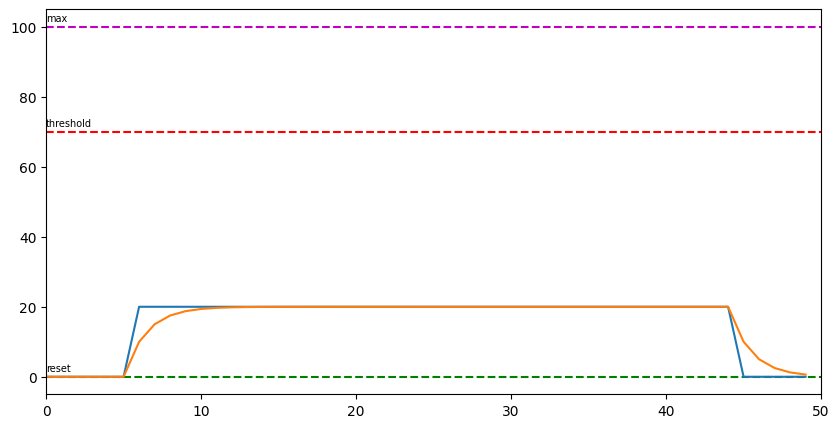

In [ ]:
#@title Simulation

input_history = []
output_history = []
simple_neuron = Simple_Neuron()

print(f'Initial Value: {simple_neuron.value}')

x_buffer = 5#24
x_max = 50
for timestep in range(x_max):
  input = 0
  if timestep > x_buffer and timestep < x_max-x_buffer:
    input = 20 #5*np.sin(timestep) + 5

  input_history.append(input)
  output_history.append(simple_neuron.stimulate(input))



plt.figure(3, figsize=(10, 5))
plt.xlim([0, x_max])
plt.axhline(Simple_Constants.MAX.value, color='m', ls='dashed')
plt.text(0, Simple_Constants.MAX.value+1.5, 'max', {'size':7})
plt.axhline(Simple_Constants.RESET.value, color='g', ls='dashed')
plt.text(0, Simple_Constants.RESET.value+1.5, 'reset', {'size':7})
plt.axhline(Simple_Constants.THRESHOLD.value, color='r', ls='dashed')
plt.text(0, Simple_Constants.THRESHOLD.value+1.5, 'threshold', {'size':7})
plt.plot(input_history)
plt.plot(output_history)
plt.show()